# Conformal Prediction for Regression

## Loading Libraries

In [33]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Dat Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.ticker import FormatStrFormatter
from yellowbrick.regressor import PredictionError
from matplotlib.offsetbox import AnnotationBbox, TextArea



# SciPy
from scipy.stats import rankdata
from scipy.stats import randint, uniform

#
import openml

# Notebook Opt
from tqdm import tqdm

# Crepes
from crepes import WrapRegressor
from crepes.extras import binning
from crepes.extras import DifficultyEstimator

# Mapie
from mapie.subsample import Subsample
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score

# Scikit-Learn
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.preprocessing import label_binarize, OrdinalEncoder

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingRegressor

# Boosting Libraries
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Conformal Libraries
from nonconformist.nc import NcFactory
from nonconformist.cp import IcpClassifier
from nonconformist.cp import TcpClassifier
from nonconformist.base import ClassifierAdapter
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc, ClassifierNc

In [118]:
import warnings
warnings.filterwarnings('ignore')

- Mandatory Libraries

!pip install dtype_diet
!pip install openml
!pip install mapie
!pip install crepes
!pip install aws-fortuna

In [35]:
%matplotlib inline

In [37]:
random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

- Loading Data: https://docs.openml.org/Python-API/

In [39]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [41]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


### California Data Information

In [43]:
datasets_df.loc[43939]

name                                  california_housing
version                                                1
uploader                                           30861
status                                            active
format                                              ARFF
MajorityClassSize                                    NaN
MaxNominalAttDistinctValues                          NaN
MinorityClassSize                                    NaN
NumberOfClasses                                      0.0
NumberOfFeatures                                    10.0
NumberOfInstances                                20640.0
NumberOfInstancesWithMissingValues                 207.0
NumberOfMissingValues                              207.0
NumberOfNumericFeatures                              9.0
NumberOfSymbolicFeatures                             1.0
Name: 43939, dtype: object

In [45]:
dataset = openml.datasets.get_dataset(43939)

# Retrieving Summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'california_housing', the target feature is 'median_house_value'
URL: https://api.openml.org/data/v1/download/22102987/california_housing.arff
Median house prices for California districts derived from the 1990 census.


In [47]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

df = pd.DataFrame(X, columns=attribute_names)

df["class"] = y

### Checking for Categorical Variables

In [49]:
categorical_indicator

[False, False, False, False, False, False, False, False, True]

In [51]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,3.0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,342200.0


In [53]:
df['ocean_proximity'].unique()

array([3., 0., 1., 4., 2.], dtype=float32)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   ocean_proximity     20640 non-null  float32
 9   class               20640 non-null  float64
dtypes: float32(9), float64(1)
memory usage: 887.0 KB


In [57]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [59]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
class                   0
dtype: int64

In [61]:
df.dropna(subset=['total_bedrooms'], inplace=True)

In [63]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [65]:
# Features
X = df.drop('class', axis = 1)

# Target
y = df['class']

## Inductive Conformal Prediction

For ICP is required:

- Splitting The Datasets into 3 Datasets: `A Traininig set`, `A Calibration & Test Set`.

- The Training Set is used to train the underlying model, The Calibration Set is used by Conformal Prediction & Test Set is used to Test models

In [67]:
# Splitting Procedure
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

In [69]:
# A 1000 Objects for Calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

In [71]:
# Checking Splitting Shape:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (19333, 9), calib = (1000, 9), test = (100, 9)


In [73]:
# Setting Model
model = RandomForestRegressor(n_jobs=-1)

# Fitting Model
model.fit(X_proper_train, y_proper_train)

RandomForestRegressor(n_jobs=-1)

In [75]:
alpha = 0.05

n_cal = len(y_cal)

n_cal

1000

In [77]:
# Point Predictions on The Calibration & Test Sets
y_pred_cal = model.predict(X_cal)

y_pred_test = model.predict(X_test)

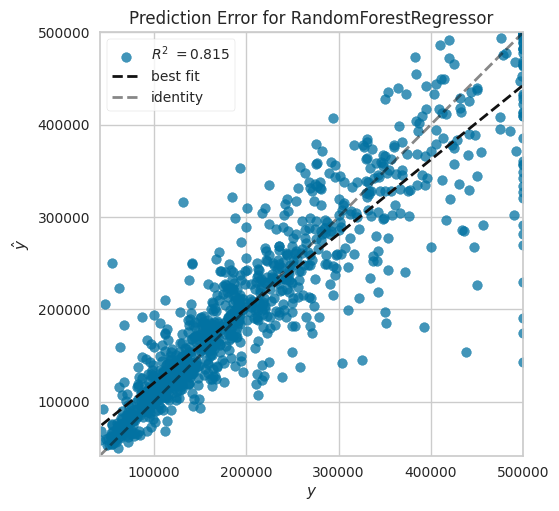

In [120]:
# Modelling Prediction Error
visualizer = PredictionError(model)

# Placing on Test set
visualizer.score(X_cal, y_cal)
visualizer.show() 
plt.show()

In [81]:
# Calibration Errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [83]:
# Quantile Calculation with Coverage Final Sample Adjustment
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.951

- q_hat on Calibration Set

In [85]:
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)

q_yhat_cal

108735.18142999995

### Calibration Error

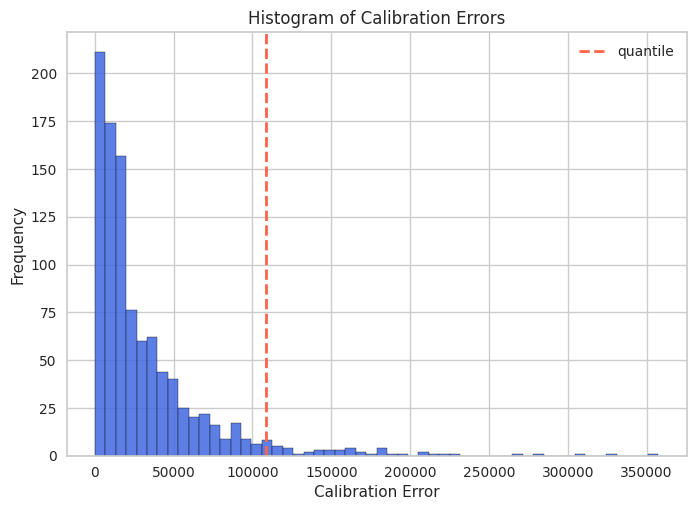

In [87]:
plt.hist(y_cal_error, bins='auto', color='royalblue', edgecolor='black', alpha=0.85)

plt.axvline(q_yhat_cal, color='tomato', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')

plt.show()

### RandomForestRegressor Model Prediction Error

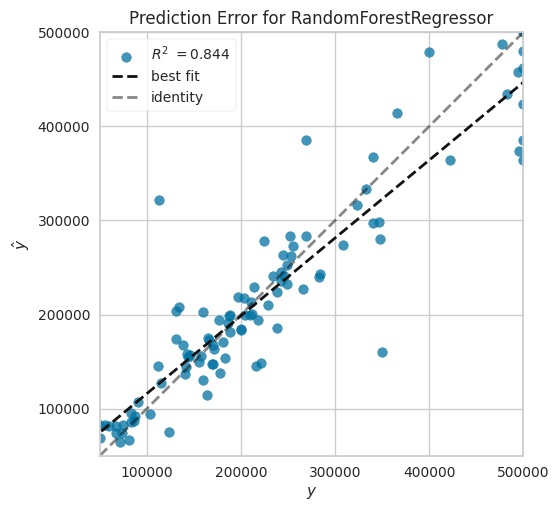

In [89]:
visualizer = PredictionError(model)

#Test Model Evaluation
visualizer.score(X_test, y_test)

# Rendering
visualizer.show()  
plt.show()

In [91]:
# Lower `yhat`
y_hat_test_lower = y_pred_test - q_yhat_cal

# Upper `yhat`
y_hat_test_upper = y_pred_test + q_yhat_cal

- Retrieving Outcomes:

In [93]:
predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])

predict_df

,actual,predicted,lower_bound,upper_bound
0,245800.0,241162.00,132426.81857,349897.18143
1,137900.0,168071.00,59335.81857,276806.18143
2,218200.0,194517.00,85781.81857,303252.18143
3,220800.0,148880.00,40144.81857,257615.18143
4,170500.0,167505.00,58769.81857,276240.18143
...,...,...,...,...
95,50000.0,69046.00,-39689.18143,177781.18143
96,500001.0,423684.44,314949.25857,532419.62143
97,55000.0,82294.00,-26441.18143,191029.18143
98,204200.0,199039.00,90303.81857,307774.18143


- Coverage Function:

In [95]:
def calculate_coverage(df):
    df['in_interval'] = df.apply(lambda row: row['lower_bound'] <= row['actual'] <= row['upper_bound'], axis=1)
    coverage = df['in_interval'].mean()
    return coverage

coverage = calculate_coverage(predict_df)
print(f"Coverage: {coverage}")

Coverage: 0.94


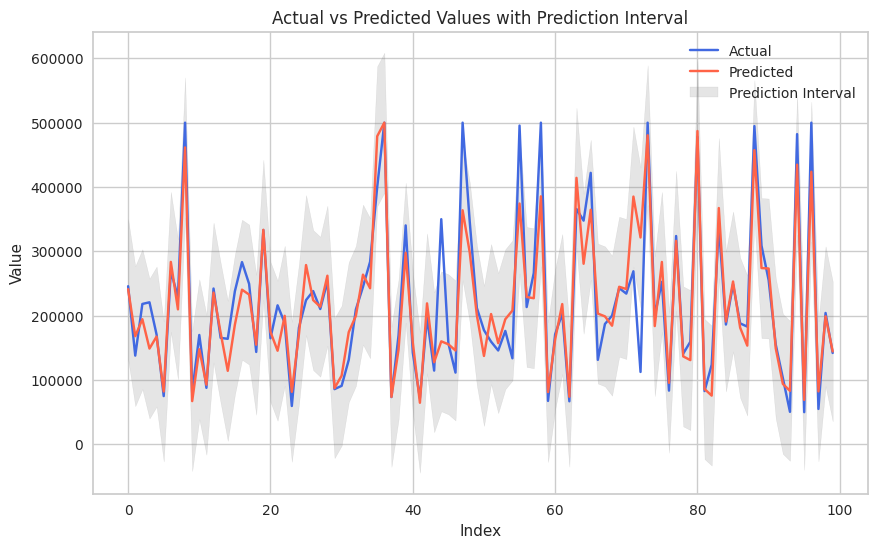

In [97]:
plt.figure(figsize=(10, 6))

# Actual Values
plt.plot(predict_df['actual'], label='Actual', color='royalblue')
# Predicted Values
plt.plot(predict_df['predicted'], label='Predicted', color='tomato')
# Prediction Intervals
plt.fill_between(predict_df.index, predict_df['lower_bound'], predict_df['upper_bound'],
                 color='gray', alpha=0.2, label='Prediction Interval')

# Legend
plt.legend(loc='upper right')
# Set labels & Title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')

plt.show()

### Mathematical Reasoning retrieved from:

1. The distribution of coverage follows the equation:

$$
\mathbb{E}\left[1\{y \in C(x_{\text{val}})\} \mid \{(x_i, y_i)\}_{i=1}^{n_{\text{cal}}} \right]
\sim \text{Beta}(n_{\text{cal}} + 1 - l, l)
$$

2. Calculating empirical coverage using \( T \) trials and verifying whether it fits the Beta distribution:

$$
C_j = \frac{1}{n_{\text{val}}} \sum_{i=1}^{n_{\text{val}}} 1\{y_i \in C(x_{\text{val}})\},
\quad j \in \{1, 2, \dots, T\}.
$$


#### Trial Function, as follows:

##### 1. Splitting the datasets into 3 datasets: Proper `Training Set`, `Calibration` and `Test Set`.
   
##### 2. A proper `Training Set` is used to train the underlying model, `Calibration Set` is used by `Conformal Prediction`

##### 3. A `Test Set` is used to Test models

In [99]:
def trial_func():
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

  # 1000 Objects for Calibration
  X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

  # Placing Random Forest Regressor to Train The Underlying Model
  model = RandomForestRegressor(n_jobs=-1)
  model.fit(X_proper_train, y_proper_train)

  # Getting Predictions Points on the Calibration & Test Sets
  y_pred_cal = model.predict(X_cal)
  y_pred_test = model.predict(X_test)

  # Calculating Calibration Errors
  y_cal_error = np.abs(y_cal - y_pred_cal)

  # Calculating q_hat on The Calibration Set
  q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)

  # ComputING Upper & Lower Bounds
  y_hat_test_lower = y_pred_test - q_yhat_cal
  y_hat_test_upper = y_pred_test + q_yhat_cal

  # Create Dataframe with Prediciton Results
  predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])

  coverage = calculate_coverage(predict_df)
  return coverage

In [101]:
trial_func()

0.94

### Regression Coverage Score

In [103]:
regression_coverage_score(predict_df['actual'].values, predict_df['lower_bound'].values, predict_df['upper_bound'].values)

0.94

In [105]:
regression_mean_width_score(predict_df['lower_bound'].values, predict_df['upper_bound'].values)

217470.3628599999

In [107]:
2*q_yhat_cal

217470.3628599999

## Conformalized Quantile Regression, Jackknife+ & more (MAPIE)

From Author:

- The target variable of this dataset is the median house value for the California districts.

- This dataset is composed of 8 features, including ariables such as the age of the house, the median income of the neighborhood, the average numbe rooms or bedrooms or even the location in latitude and longitude. In total there are around 20k observations.

In [109]:
pear_corr = df.corr(method='pearson')

pear_corr.style.background_gradient(cmap='Greens', axis=0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.289530,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,0.200801,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.112330,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,-0.015363,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,-0.014768,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.069630,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,-0.018251,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,-0.014679,0.688355
ocean_proximity,-0.289530,0.200801,0.112330,-0.015363,-0.014768,-0.069630,-0.018251,-0.014679,1.000000,0.080488
class,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,0.080488,1.000000


### Housing Prices Bins

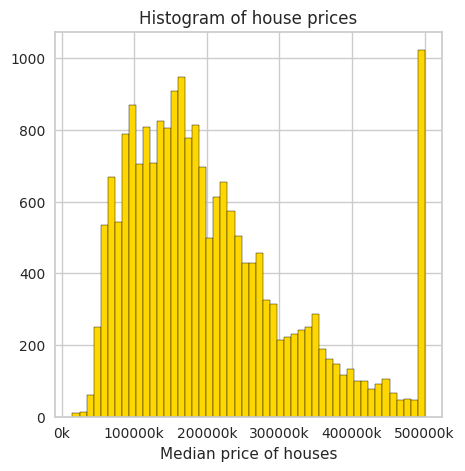

In [111]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(y, bins=50, edgecolor='black', color='gold')
axs.set_xlabel("Median price of houses")
axs.set_title("Histogram of house prices")
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
plt.show()

### Optimize Underlying Model

In [113]:
# Placing Estimator (Light Gradient Boosting Regressor)
estimator = LGBMRegressor(objective='quantile', alpha=0.5, random_state=random_state)

# Parameter Distribution
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)

# Model Optimization
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=0
)

# Fitting Model
optim_model.fit(X_train, y_train)

# Getting Best Estimator
estimator = optim_model.best_estimator_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [122]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True house prices in $")
    axs.set_ylabel("Prediction of house prices in $")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            + f"Interval width: {np.round(width, round_to)}"
        ),
        xy=(np.min(y_test_sorted_)*3, np.max(y_pred_sorted_+error)*0.95),
        )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

In [124]:
STRATEGIES = {
    "naive": {"method": "naive"},
    "cv_plus": {"method": "plus", "cv": 10},
    "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    "cqr": {"method": "quantile", "cv": "split", "alpha": 0.2},
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)
        mapie.fit(
            X_train, y_train,
            X_calib=X_cal, y_calib=y_cal,
            random_state=random_state
        )
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(estimator, **params, random_state=random_state)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    (
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy]
    ) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )
    width[strategy] = regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 20333, number of used features: 9
[LightGBM] [Info] Start training from score 179600.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 20333, number of used features: 9
[LightGBM] [Info] Start training from score 179600.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

### Plotting Coverage

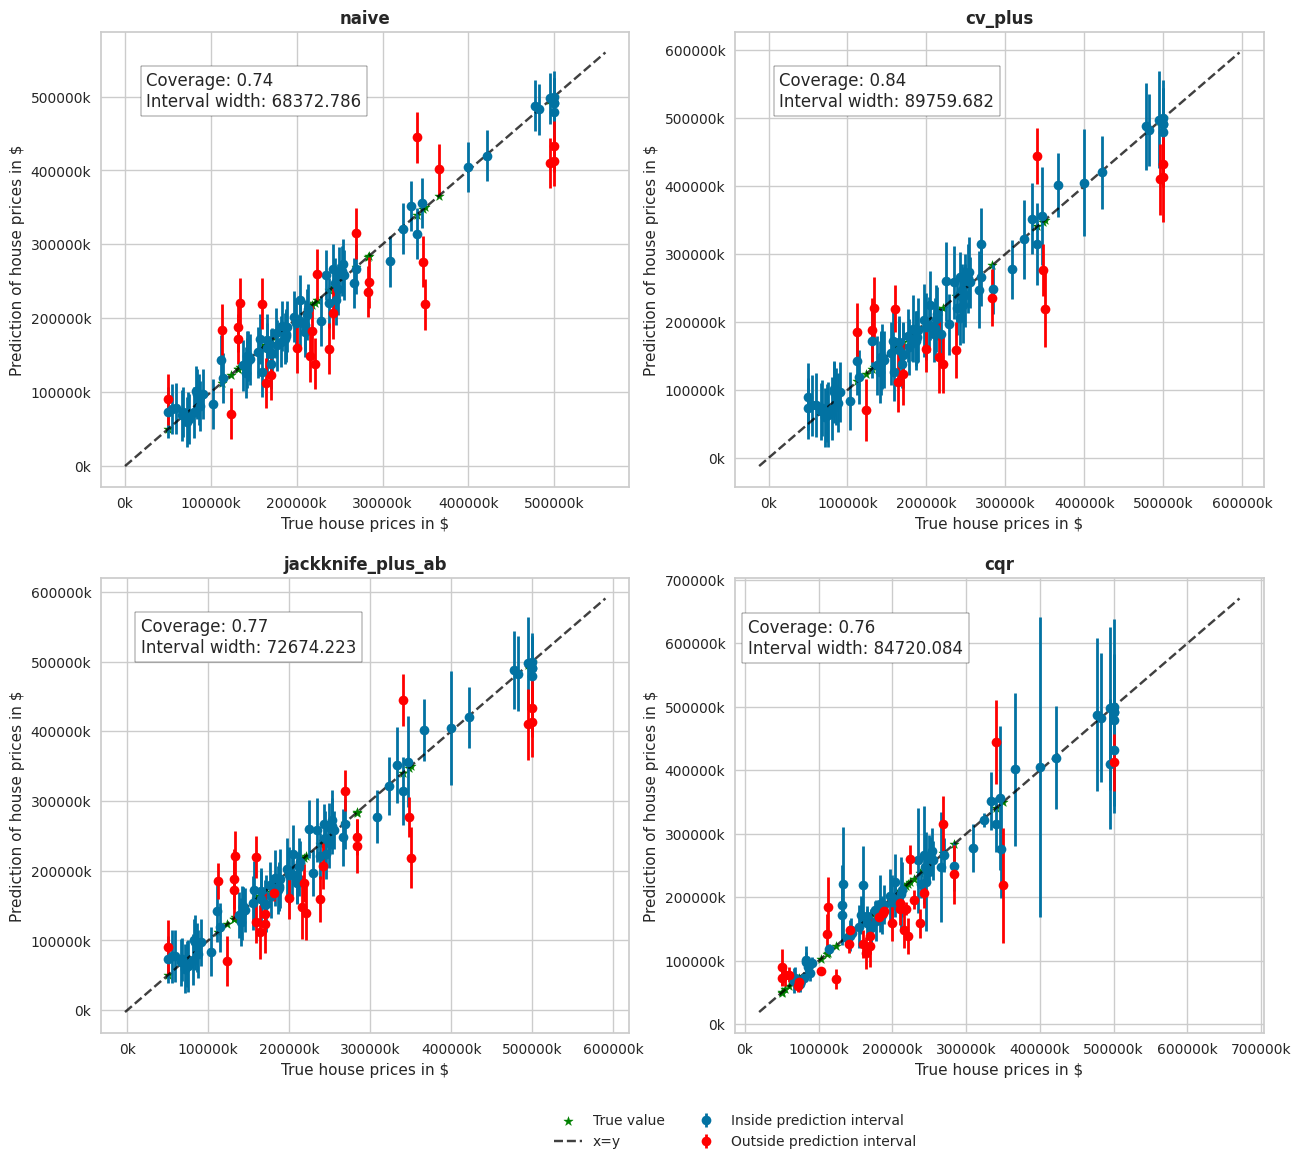

In [126]:
perc_obs_plot = 1
num_plots = rng.choice(
    len(y_test), int(perc_obs_plot*len(y_test)), replace=False
    )
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
for strategy, coord in zip(STRATEGIES.keys(), coords):
    plot_prediction_intervals(
        strategy,
        coord,
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy],
        coverage[strategy],
        width[strategy],
        num_plots
        )
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(0, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2
)
plt.show()

In [128]:
def get_coverages_widths_by_bins(
    want,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
):
    """
    Given the results from MAPIE, this function split the data
    according the the test values into bins and calculates coverage
    or width per bin.
    """
    cuts = []
    cuts_ = pd.qcut(y_test["naive"], bins).unique()[:-1]
    for item in cuts_:
        cuts.append(item.left)
    cuts.append(cuts_[-1].right)
    cuts.append(np.max(y_test["naive"])+1)
    recap = {}
    for i in range(len(cuts) - 1):
        cut1, cut2 = cuts[i], cuts[i+1]
        name = f"[{np.round(cut1, 0)}, {np.round(cut2, 0)}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where(
                (y_test[strategy] > cut1) * (y_test[strategy] <= cut2)
                )
            y_test_trunc = np.take(y_test[strategy], indices)
            y_low_ = np.take(lower_bound[strategy], indices)
            y_high_ = np.take(upper_bound[strategy], indices)
            if want == "coverage":
                recap[name].append(regression_coverage_score(
                    y_test_trunc[0],
                    y_low_[0],
                    y_high_[0]
                ))
            elif want == "width":
                recap[name].append(
                    regression_mean_width_score(y_low_[0], y_high_[0])
                )
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df


bins = list(np.arange(0, 1, 0.1))
binned_data = get_coverages_widths_by_bins(
    "coverage",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
)

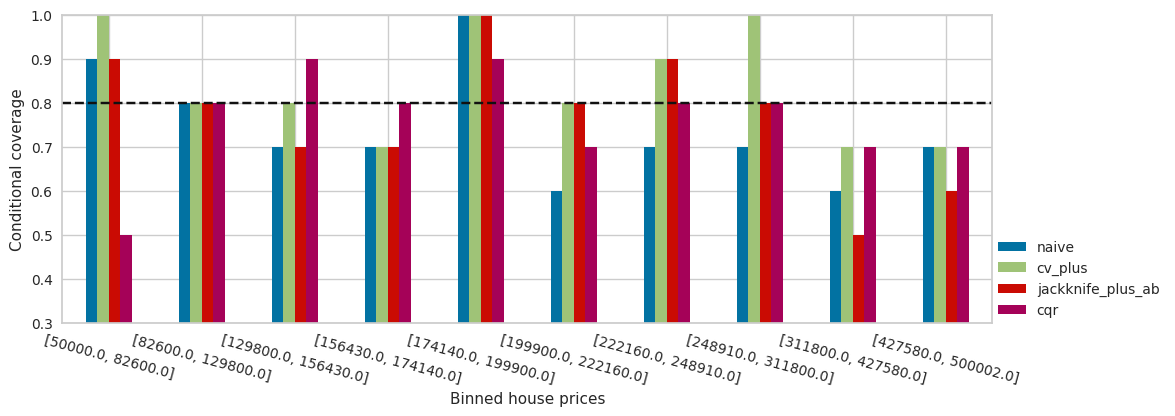

In [130]:
binned_data.T.plot.bar(figsize=(12, 4))

plt.axhline(0.80, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.xlabel("Binned house prices")
plt.xticks(rotation=345)
plt.ylim(0.3, 1.0)
plt.legend(loc=[1, 0])

plt.show()

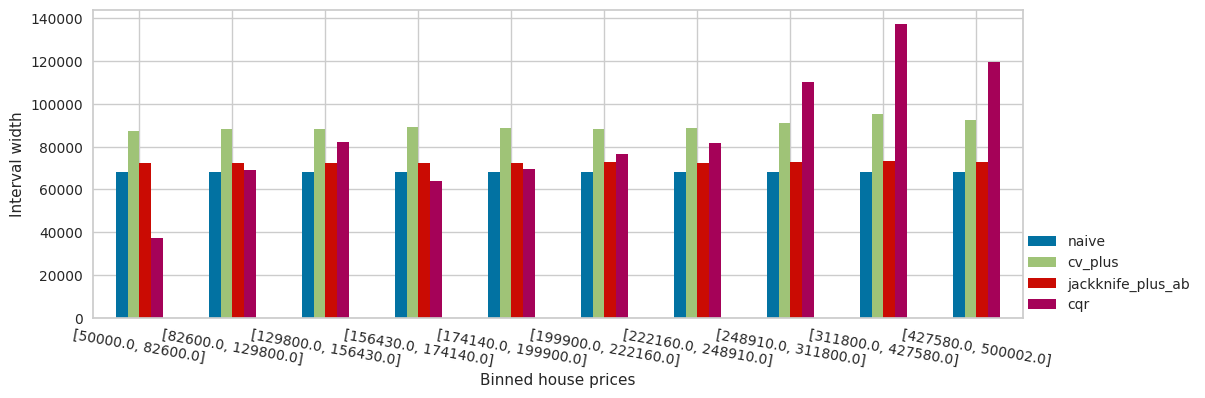

In [132]:
binned_data = get_coverages_widths_by_bins(
    "width",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
)


binned_data.T.plot.bar(figsize=(12, 4))
plt.ylabel("Interval width")
plt.xlabel("Binned house prices")
plt.xticks(rotation=350)
plt.legend(loc=[1, 0])
plt.show()

## Conformal Predictive Distributions (Crepes)

In [140]:
dataset = fetch_openml("house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

### RandomForestRegressor

In [142]:
# Placing Class() WrapRegressor within Model Regressor
rf = WrapRegressor(RandomForestRegressor())

# Model Fitting
rf.fit(X_prop_train, y_prop_train)

In [144]:
# Placing Calibration Set
rf.calibrate(X_cal, y_cal)

WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

In [146]:
# Prediction on 99%
rf.predict_int(X_test, confidence=0.99)

array([[-321548.25,  848698.25],
       [-229499.41,  940747.09],
       [ 582057.25, 1752303.75],
       ...,
       [-357866.75,  812379.75],
       [-227980.5 ,  942266.  ],
       [ 238691.43, 1408937.93]])

In [148]:
rf.predict_int(X_test, y_min=0)

array([[   8280.57,  518869.43],
       [ 100329.41,  610918.27],
       [ 911886.07, 1422474.93],
       ...,
       [      0.  ,  482550.93],
       [ 101848.32,  612437.18],
       [ 568520.25, 1079109.11]])

In [150]:
# de = DifficultyEstimator()
# de.fit(X_prop_train, y=y_prop_train)

# sigmas_cal = de.apply(X_cal)

In [152]:
help(rf.calibrate)

Help on method calibrate in module crepes.base:

calibrate(X, y, de=None, mc=None, oob=False, cps=False, seed=None) method of crepes.base.WrapRegressor instance
    Fit a :class:`.ConformalRegressor` or 
    :class:`.ConformalPredictiveSystem` using the wrapped learner.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features),
       set of objects
    y : array-like of shape (n_samples,),
        target values
    de: :class:`crepes.extras.DifficultyEstimator`, default=None
        object used for computing difficulty estimates
    mc: function or :class:`crepes.extras.MondrianCategorizer`, default=None
        function or :class:`crepes.extras.MondrianCategorizer` for computing Mondrian categories
    oob : bool, default=False
       use out-of-bag estimation
    cps : bool, default=False
        if cps=False, the method fits a :class:`.ConformalRegressor`
        and otherwise, a :class:`.ConformalPredictiveSystem`
    seed : int, default=None
       se

In [154]:
de = DifficultyEstimator()
de.fit(X_prop_train, y=y_prop_train)

rf.calibrate(X_cal, y_cal, de=de)

WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

In [156]:
# rf.calibrate(X_cal, y_cal, sigmas=sigmas_cal)

In [158]:
sigmas_test = de.apply(X_test)
crepes_predictions = rf.predict_int(X_test, y_min=0)

crepes_predictions

array([[ 211407.70059662,  315742.29940338],
       [ 313522.07239701,  397725.60760299],
       [ 904781.62294791, 1429579.37705209],
       ...,
       [ 173516.33531721,  280996.66468279],
       [ 260814.12032126,  453471.37967874],
       [ 601649.85594611, 1045979.50405389]])

In [160]:
predict_crepes_df = pd.DataFrame(list(zip(y_test,crepes_predictions[:,0],crepes_predictions[:,1])),
                  columns=['actual','lower_bound','upper_bound'])

predict_crepes_df

,actual,lower_bound,upper_bound
0,267000.0,211407.700597,3.157423e+05
1,314000.0,313522.072397,3.977256e+05
2,1378600.0,904781.622948,1.429579e+06
3,322500.0,85118.168210,4.563811e+05
4,1600000.0,646276.753598,1.688193e+06
...,...,...,...
10802,395000.0,219966.164253,5.655788e+05
10803,770000.0,544249.245438,8.643683e+05
10804,236000.0,173516.335317,2.809967e+05
10805,359800.0,260814.120321,4.534714e+05


In [162]:
def plot_predictions(df):
  # Calculate coverage
  coverage = calculate_coverage(df)
  print(f"Coverage: {coverage}")

  # Determine the color for each actual value based on whether it falls within the prediction interval
  colors = np.where(
      (df['actual'] >= df['lower_bound']) &
      (df['actual'] <= df['upper_bound']),
      'blue', 'red'
  )

  # Create traces for the plot
  trace_actual = go.Scatter(
      x=df.index,
      y=df['actual'],
      mode='markers',
      marker=dict(color=colors.tolist()),
      name='Actual',
  )

  trace_interval = go.Scatter(
      x=df.index.tolist() + df.index.tolist()[::-1],  # x, then x reversed
      y=df['upper_bound'].tolist() + df['lower_bound'].tolist()[::-1],  # upper, then lower reversed
      fill='toself',
      fillcolor='rgba(255,165,0,0.5)',  # Adjusted alpha to 0.5 for better visibility
      line=dict(color='rgba(255,165,0,1)'),  # Adjusted line color to match fill color
      name='Prediction Interval',
  )

  # Create a layout for the plot
  layout = go.Layout(
      title=f'Actual vs Predicted Values with Prediction IntervalCoverage: {coverage:.2%}',
      xaxis_title='Index',
      yaxis_title='Value',
      template='plotly',
      margin=dict(l=60, r=30, b=50, t=50),
  )

  # Create the figure and display the plot
  fig = go.Figure(data=[trace_interval, trace_actual], layout=layout)
  fig.show()

In [164]:
plot_predictions(predict_crepes_df)

Coverage: 0.9556768760988248


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc29d8a5-7594-470f-aa28-01c12f73a1ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>